In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, PReLU, BatchNormalization, LeakyReLU, Dense, add, Flatten, UpSampling2D, Input
from sklearn.model_selection import train_test_split

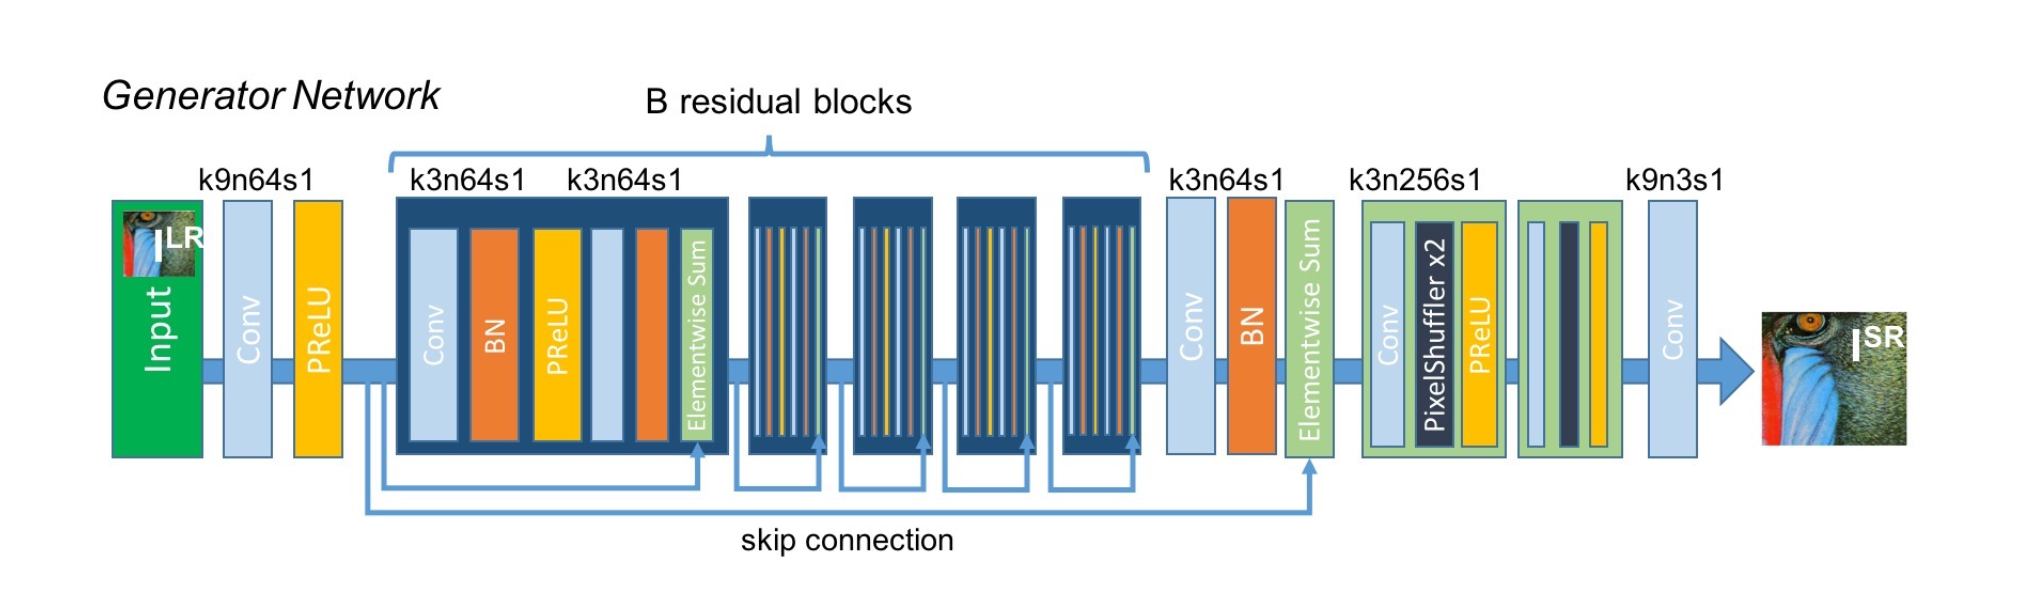

In [4]:
def residual_block(inp):
    
    residual_block = Conv2D(64, (3,3), padding = 'same')(inp)
    residual_block = BatchNormalization(momentum = 0.5)(residual_block)
    residual_block = PReLU(shared_axes = [1,2])(residual_block)
    
    residual_block = Conv2D(64, (3,3), padding = 'same')(residual_block)
    residual_block = BatchNormalization(momentum = 0.5)(residual_block)
    
    return add(inp, residual_block)


In [5]:
def upscale_block(inp):
    
    upscale_block = Conv2D(256, (3,3), padding = 'same')(inp)
    upscale_block = UpSampling2D(size = 2)(upscale_block)
    upscale_block = PReLU(shared_axes = [1,2])(upscale_block)
    
    return upscale_block

In [7]:
def generator(inp, number_res_blocks = 16):
    
    gen = Conv2D(64, (9,9), padding = 'same')(inp)
    gen = PReLU(shared_axes = [1,2])(gen)
    
    temp = gen
    
    for _ in range(number_res_blocks):
        gen = residual_block(gen)
        
    gen = Conv2D(63, (3,3), padding = 'same')(gen)
    gen = BatchNormalization(momentum = 0.5)(gen)
    gen = add([gen,temp])
    
    gen = upscale_block(gen)
    gen = upscale_block(gen)
    
    output = Conv2D(3, (9,9), padding = 'same')(layers)
    
    return Model(inputs = inp, output = output)

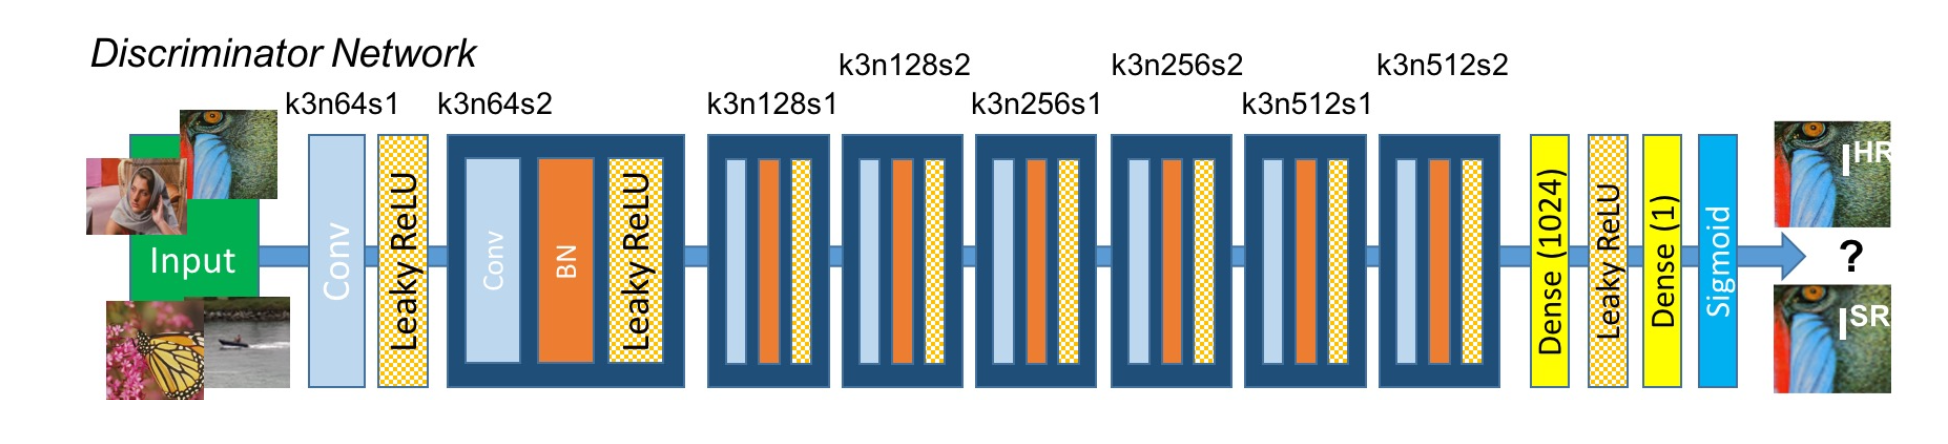

In [8]:
def disc_block(inp, filters, bn = True, strides = 1):
    
    disc = Conv2D(filters, (3,3), padding = 'same', strides = strides)(inp)
    if bn:
        disc = BatchNormalization(momentum = 0.8)(disc)
    
    disc = LeakyReLU(alpha = 0.2)(disc)
    
    return disc

In [9]:
def create_discriminator(inp):

    filters = 64
    
    d1 = disc_block(inp, filters = filters, bn = False)
    d2 = disc_block(d1, filters = filters, strides = 2)
    d3 = disc_block(d2, filters = filters * 2)
    d4 = disc_block(d3, filters = filters * 2, strides = 2)
    d5 = disc_block(d4, filters = filters * 4)
    d6 = disc_block(d5, filters = filters * 4, strides = 2)
    d7 = disc_block(d6, filters = filters * 8)
    d8 = disc_block(d6, filters = filters * 8, strides = 2)
    
    d9 = Flatten()(d8)
    d10 = Dense(filters * 16)(d9)
    d11 = LeakyReLU()(d10)
    d12 = Dense(1, activation = 'sigmoid')(d11)
    
    return Model(inp, d12)